In [3]:
%matplotlib inline
import yt
import numpy as np
from galaxy_analysis.plot.plot_styles import *
from galaxy_analysis.analysis import Galaxy
import matplotlib.pyplot as plt

from scipy.stats import pearsonr

In [4]:
wdir = "/home/aemerick/work/enzo_runs/mixing_experiment/AGB1/"
wdir = "/home/aemerick/work/enzo_runs/sn_H2atten_H2sh/"
wdir = './test/'

gal = Galaxy('DD0419',wdir=wdir)

Parsing Hierarchy : 100%|██████████| 2002/2002 [00:00<00:00, 7631.72it/s] 


In [ ]:
#
# Try the correlation coefficient
#

metal_field = 'Na_Fraction'

width = 5.0*yt.units.pc
rvals = np.arange(0.0, 600.0, 10.) * yt.units.pc + 0.5*width

rand_x = 0.0
rand_y = 0.0

center = gal.ds.domain_center.to('pc') + np.array([rand_x, rand_y, 0.0])*yt.units.pc

sp     = gal.ds.sphere( center, np.max(rvals) + 2.0*width)

coeff = np.zeros(np.size(rvals))

for i in np.arange(np.size(rvals)-1):
    
    
    s_x      = sp[metal_field].value
    r_x      = sp['spherical_radius'].to('pc').value
    
    select   = (r_x >= (rvals[i] - 0.5*width)) * (r_x < (rvals[i] + 0.5*width))
    
    coeff[i] = np.corrcoef(s_x[select])


In [38]:
#fig,ax = plt.subplots()
#fig.set_size_inches(6,6)
#
#ax.plot(rvals, coeff, lw = 3, color = 'black')

In [10]:
#
#
# 1) Pick N random points in the galaxy (Rvec)
# 2) compute S_x at each point
# 3) For each point in Rvec, pick N random points that are a distance r from that point (S_x')
# 4) Compute correlation between S_x and S_x'
# 5) Repeat for increasing r
#

In [4]:
#
#
#

metal_field = "Ba_Fraction"

N      = 1000
rmax   = 600.0
domain_width = gal.ds.domain_width
center = gal.ds.domain_center.to('pc') / domain_width



theta = np.random.rand(N) * np.pi * 2.0
r_cyl = np.random.rand(N) * 600.0**2

xvec  = (np.sqrt(r_cyl) * np.cos(theta)) * yt.units.pc / domain_width[0] + center[0]
yvec  = (np.sqrt(r_cyl) * np.cos(theta)) * yt.units.pc / domain_width[1] + center[1]
zvec  = (np.zeros(N))                    * yt.units.pc / domain_width[2] + center[2]

pt_x  = [ gal.ds.r[ [xvec[i].value, yvec[i].value, zvec[i].value] ] for i in np.arange(N)]
S_x   = np.array([p[metal_field][0] for p in pt_x])

rsample   = np.arange(0,600.0,10.0)
corrcoeff = np.zeros(np.size(rsample))

for i in np.arange(np.size(rsample)):
    
    theta = np.random.rand(N) * np.pi * 2.0
    r_cyl = np.random.rand(N) * (rsample[i])**2.0

    xprime  = (np.sqrt(r_cyl) * np.cos(theta)) * yt.units.pc / domain_width[0] + xvec
    yprime  = (np.sqrt(r_cyl) * np.cos(theta)) * yt.units.pc / domain_width[1] + yvec
    zprime  = (np.zeros(N))                    * yt.units.pc / domain_width[2] + zvec
    
    pt_x_prime = [ gal.ds.r[ [xprime[j].value,yprime[j].value,zprime[j].value]] for j in np.arange(N)]
    S_x_prime  = np.array([p[metal_field][0] for p in pt_x_prime])
    
    corrcoeff[i] = pearsonr(S_x, S_x_prime)[0]
    
ba_coeff = 1.0 * corrcoeff

In [103]:

def correlation(metal_field, gal, rmax = 600.0, N = 100, Niter = 1, 
                verbose = False, test_uniform = False, test_scaled = False, test_cold = False,
                test_random = False):
    
    
    
    domain_width = gal.ds.domain_width
    center = gal.ds.domain_center.to('pc') / domain_width
    rsample   = np.arange(0,600.0, 25.0)

    corrcoeff = [np.zeros(np.size(rsample))] * Niter

    for k in np.arange(Niter):
        
        if verbose:
            print(k)
        
        
        if test_random or test_cold: # well, not really... test if selecting enriched points makes a difference
            fieldval = gal.disk[metal_field]
            
            if not test_cold:
                select   = fieldval > np.sum(fieldval * gal.disk['cell_mass']) / np.sum(gal.disk['cell_mass'])
            else:
                select   = gal.disk['Temperature'] < 1000.0
            
            indeces  = np.random.choice(np.argwhere(select).flatten(), N)
            
            xvec     = gal.disk['x'][indeces].to('pc') / gal.ds.domain_width[0].to('pc')
            yvec     = gal.disk['y'][indeces].to('pc') / gal.ds.domain_width[1].to('pc')
            zvec     = gal.disk['z'][indeces].to('pc') / gal.ds.domain_width[2].to('pc')
            
        else:
            theta = np.random.rand(N) * np.pi * 2.0
            r_cyl = np.random.rand(N) * 600.0**2

            xvec  = (np.sqrt(r_cyl) * np.cos(theta)) * yt.units.pc / domain_width[0] + center[0]
            yvec  = (np.sqrt(r_cyl) * np.cos(theta)) * yt.units.pc / domain_width[1] + center[1]
            zvec  = (np.zeros(N))                    * yt.units.pc / domain_width[2] + center[2]

        pt_x  = [ gal.ds.r[ [xvec[i].value, yvec[i].value, zvec[i].value] ] for i in np.arange(N)]
        S_x   = np.array([p[metal_field][0] for p in pt_x])


        Sx_select = np.array([True]*np.size(S_x))
        if not test_uniform and not test_scaled:
            for i in np.arange(np.size(rsample)):
                print(i)
    
    
                if not test_cold:
                    theta = np.random.rand(N) * np.pi * 2.0
                    r_cyl = np.random.rand(N) * (rsample[i])**2.0
                    
                    # need to look at 3D here!?! random over scale height or sphere?

                    xprime  = (np.sqrt(r_cyl) * np.cos(theta)) * yt.units.pc / domain_width[0] + xvec
                    yprime  = (np.sqrt(r_cyl) * np.cos(theta)) * yt.units.pc / domain_width[1] + yvec
                    zprime  = (np.zeros(N))                    * yt.units.pc / domain_width[2] + zvec
                
                else:
                    rmin = rsample[i]
                    if i == np.size(rsample)-1:
                        rmax = rsample[i] + (rsample[i] - rsample[i-1])
                    else:
                        rmax = rsample[i+1]
                        
                    xprime = np.zeros(np.size(xvec)) * gal.ds.domain_width[0] / gal.ds.domain_width[0]
                    yprime = np.zeros(np.size(yvec)) * gal.ds.domain_width[1] / gal.ds.domain_width[1]
                    zprime = np.zeros(np.size(zvec)) * gal.ds.domain_width[2] / gal.ds.domain_width[2]
                    
                    for j in np.arange(np.size(xvec)):
                        sp     = gal.ds.sphere( [xvec[j].value,yvec[j].value,zvec[j].value], rmax * yt.units.pc)
                        select = (sp['spherical_radius'] > rmin) * (sp['Temperature'] < 1000.0)                    
                        
                        index = np.random.choice(np.argwhere(select).flatten(),1)
                        
                        if np.size(index) < 1:
                            
                            Sx_select[j] = False
                        else:
                            Sx_select[j] = True
                        
                        xprime[j] = sp['x'][index].to('pc') / gal.ds.domain_width[0].to('pc')
                        yprime[j] = sp['y'][index].to('pc') / gal.ds.domain_width[1].to('pc')
                        zprime[j] = sp['z'][index].to('pc') / gal.ds.domain_width[2].to('pc')
                        
    
                pt_x_prime = [ gal.ds.r[ [xprime[j].value,yprime[j].value,zprime[j].value]] for j in np.arange(N)]
                S_x_prime  = np.array([p[metal_field][0] for p in pt_x_prime])
    
                corrcoeff[k][i] = pearsonr(S_x, S_x_prime)[0]
        
        elif test_uniform:
            for i in np.arange(np.size(rsample)):
                corrcoeff[k][i] = pearsonr(S_x, S_x)[0]
        elif test_scaled:
            for i in np.arange(np.size(rsample)):
                corrcoeff[k][i] = pearsonr(S_x, S_x * (i / (1.0*np.size(rsample))))[0]
                
    
    
    answer = np.mean(corrcoeff, axis = 0)
    
    return answer


In [104]:
x = np.array([0,1,2,3,4,5,6]) + 120
print(x[ np.array([5,2])])

print(np.argwhere(x>2).flatten())


sp = gal.ds.sphere(gal.ds.domain_center, 5*yt.units.pc)
sp['x'].to('pc')

[125 122]
[0 1 2 3 4 5 6]


YTArray([29489.29154562, 29489.29154562, 29489.29154562, 29489.29154562,
         29494.69152576, 29494.69152576, 29494.69152576, 29494.69152576]) pc

In [105]:
fields = ['O_Fraction','Ba_Fraction']

In [106]:
corrdict = {}

N     = 500
Niter = 1

corrdict['cold'] = correlation('Ba_Fraction', gal, N=N, Niter= Niter, test_cold=True)

corrdict['enriched'] = correlation('Ba_Fraction', gal, N=N, Niter= Niter, test_random=True)


for f in fields:
    print(f)
    corrdict[f] = correlation(f, gal, N = N, Niter = Niter, verbose = True)
    
#corrdict['uniform'] = correlation('O_Fraction', gal, N=N, Niter= Niter, test_uniform = True)
#corrdict['scaled']  = correlation('O_Fraction', gal, N=N, Niter= Niter, test_scaled  = True)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
O_Fraction
0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
Ba_Fraction
0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


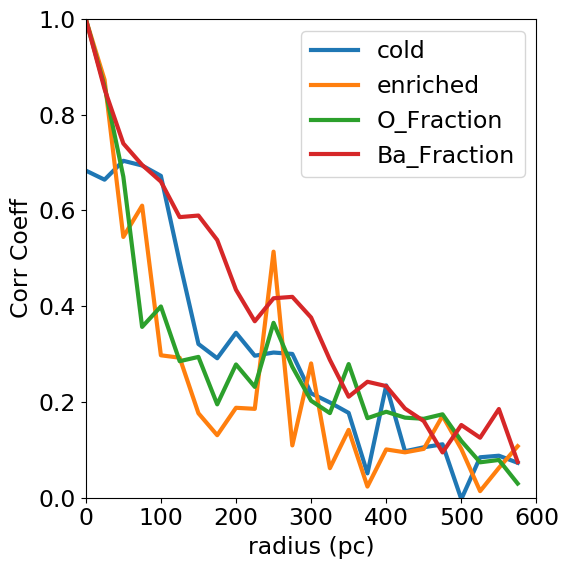

In [107]:
fig,ax = plt.subplots()
fig.set_size_inches(6,6)

rsample   = np.arange(0,600.0, 25.0)

for f in corrdict.keys():
    ax.plot(rsample, corrdict[f],  lw = 3, label = f)
    
ax.set_xlim(0,600)
ax.set_ylim(0.0,1.0)

ax.set_xlabel(r'radius (pc)')
ax.set_ylabel(r'Corr Coeff')
ax.legend(loc='best')

plt.tight_layout()

fig.savefig('2metal_correlation_DD0419_O_Ba.png')



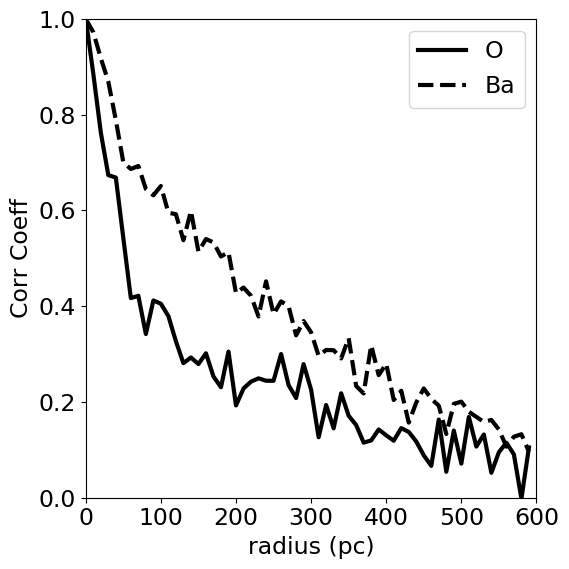

In [7]:
fig,ax = plt.subplots()
fig.set_size_inches(6,6)

ax.plot(rsample, O_coeff,  lw = 3, color = 'black', label = 'O')
ax.plot(rsample, ba_coeff, lw = 3, color = 'black', ls = '--', label = 'Ba')

ax.set_xlim(0,600)
ax.set_ylim(0.0,1.0)

ax.set_xlabel(r'radius (pc)')
ax.set_ylabel(r'Corr Coeff')
ax.legend(loc='best')

plt.tight_layout()

fig.savefig('AGB_SNe_DD0419.png')

